<a href="https://colab.research.google.com/github/MMoronto/pytorch_exercises/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [1]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━

##Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [3]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [4]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [5]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,-0.251266,0.104848,-1.300359,-0.697802,1.852973,0.043323
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,-0.811223,-0.187225
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,-0.857178,1.185963
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,0.427609,-0.340233
2023-01-06,0.856501,0.788102,0.906213,0.381902,1.178026,1.007866
2023-01-07,-1.861371,-1.313191,0.221653,-0.729124,-0.941923,1.199410
2023-01-08,0.190275,-0.253856,0.522316,1.878686,2.018713,-1.644193


In [6]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [7]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [8]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [9]:
df.head()

,A,B,C,D,E,F
2023-01-01,-0.251266,0.104848,-1.300359,-0.697802,1.852973,0.043323
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,-0.811223,-0.187225
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,-0.857178,1.185963
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,0.427609,-0.340233


In [10]:
df.tail()

,A,B,C,D,E,F
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,-0.857178,1.185963
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,0.427609,-0.340233
2023-01-06,0.856501,0.788102,0.906213,0.381902,1.178026,1.007866
2023-01-07,-1.861371,-1.313191,0.221653,-0.729124,-0.941923,1.199410
2023-01-08,0.190275,-0.253856,0.522316,1.878686,2.018713,-1.644193


In [11]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [12]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [13]:
df.to_numpy()

array([[-0.25126613,  0.1048478 , -1.30035863, -0.69780246,  1.85297263,
         0.04332335],
       [-0.30977924,  0.24290893, -0.21046878,  1.19966124, -0.81122309,
        -0.18722543],
       [ 0.22400159, -1.22303551, -0.8016921 , -0.07891499,  0.86793041,
        -1.49330336],
       [-2.18852359, -0.11331474,  0.66104923, -0.46093113, -0.85717785,
         1.18596288],
       [-1.32440744,  0.11416138,  0.44826266, -0.22367178,  0.42760861,
        -0.34023339],
       [ 0.85650079,  0.78810228,  0.90621295,  0.38190159,  1.1780263 ,
         1.00786617],
       [-1.86137149, -1.31319105,  0.22165278, -0.72912437, -0.94192299,
         1.19941012],
       [ 0.19027462, -0.25385567,  0.52231629,  1.8786861 ,  2.01871281,
        -1.64419284]])

In [14]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [15]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,-0.583071,-0.206672,0.055872,0.158726,0.466866,-0.028549
std,1.086784,0.723088,0.768492,0.941140,1.217078,1.130132
min,-2.188524,-1.313191,-1.300359,-0.729124,-0.941923,-1.644193
25%,-1.458648,-0.496151,-0.358275,-0.520149,-0.822712,-0.628501
50%,-0.280523,-0.004233,0.334958,-0.151293,0.647770,-0.071951
75%,0.198706,0.146348,0.557000,0.586342,1.346763,1.052390
max,0.856501,0.788102,0.906213,1.878686,2.018713,1.199410


In [16]:
df

,A,B,C,D,E,F
2023-01-01,-0.251266,0.104848,-1.300359,-0.697802,1.852973,0.043323
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,-0.811223,-0.187225
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,-0.857178,1.185963
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,0.427609,-0.340233
2023-01-06,0.856501,0.788102,0.906213,0.381902,1.178026,1.007866
2023-01-07,-1.861371,-1.313191,0.221653,-0.729124,-0.941923,1.199410
2023-01-08,0.190275,-0.253856,0.522316,1.878686,2.018713,-1.644193


In [17]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,-0.251266,-0.309779,0.224002,-2.188524,-1.324407,0.856501,-1.861371,0.190275
B,0.104848,0.242909,-1.223036,-0.113315,0.114161,0.788102,-1.313191,-0.253856
C,-1.300359,-0.210469,-0.801692,0.661049,0.448263,0.906213,0.221653,0.522316
D,-0.697802,1.199661,-0.078915,-0.460931,-0.223672,0.381902,-0.729124,1.878686
E,1.852973,-0.811223,0.867930,-0.857178,0.427609,1.178026,-0.941923,2.018713
F,0.043323,-0.187225,-1.493303,1.185963,-0.340233,1.007866,1.199410,-1.644193


In [18]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,0.043323,1.852973,-0.697802,-1.300359,0.104848,-0.251266
2023-01-02,-0.187225,-0.811223,1.199661,-0.210469,0.242909,-0.309779
2023-01-03,-1.493303,0.867930,-0.078915,-0.801692,-1.223036,0.224002
2023-01-04,1.185963,-0.857178,-0.460931,0.661049,-0.113315,-2.188524
2023-01-05,-0.340233,0.427609,-0.223672,0.448263,0.114161,-1.324407
2023-01-06,1.007866,1.178026,0.381902,0.906213,0.788102,0.856501
2023-01-07,1.199410,-0.941923,-0.729124,0.221653,-1.313191,-1.861371
2023-01-08,-1.644193,2.018713,1.878686,0.522316,-0.253856,0.190275


In [19]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-07,-1.861371,-1.313191,0.221653,-0.729124,-0.941923,1.199410
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303
2023-01-08,0.190275,-0.253856,0.522316,1.878686,2.018713,-1.644193
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,-0.857178,1.185963
2023-01-01,-0.251266,0.104848,-1.300359,-0.697802,1.852973,0.043323
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,0.427609,-0.340233
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,-0.811223,-0.187225
2023-01-06,0.856501,0.788102,0.906213,0.381902,1.178026,1.007866


In [20]:
df

,A,B,C,D,E,F
2023-01-01,-0.251266,0.104848,-1.300359,-0.697802,1.852973,0.043323
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,-0.811223,-0.187225
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,-0.857178,1.185963
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,0.427609,-0.340233
2023-01-06,0.856501,0.788102,0.906213,0.381902,1.178026,1.007866
2023-01-07,-1.861371,-1.313191,0.221653,-0.729124,-0.941923,1.199410
2023-01-08,0.190275,-0.253856,0.522316,1.878686,2.018713,-1.644193


##Getting

In [21]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01   -0.251266
2023-01-02   -0.309779
2023-01-03    0.224002
2023-01-04   -2.188524
2023-01-05   -1.324407
2023-01-06    0.856501
2023-01-07   -1.861371
2023-01-08    0.190275
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [22]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,-0.251266,0.104848,-1.300359,-0.697802,1.852973,0.043323
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,-0.811223,-0.187225
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303


In [23]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,-0.811223,-0.187225
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,-0.857178,1.185963


In [24]:
df

,A,B,C,D,E,F
2023-01-01,-0.251266,0.104848,-1.300359,-0.697802,1.852973,0.043323
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,-0.811223,-0.187225
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,-0.857178,1.185963
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,0.427609,-0.340233
2023-01-06,0.856501,0.788102,0.906213,0.381902,1.178026,1.007866
2023-01-07,-1.861371,-1.313191,0.221653,-0.729124,-0.941923,1.199410
2023-01-08,0.190275,-0.253856,0.522316,1.878686,2.018713,-1.644193


##Selection by label

In [25]:
df.loc[dates[1]]

A   -0.309779
B    0.242909
C   -0.210469
D    1.199661
E   -0.811223
F   -0.187225
Name: 2023-01-02 00:00:00, dtype: float64

In [26]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,-0.251266,-0.697802
2023-01-02,-0.309779,1.199661
2023-01-03,0.224002,-0.078915
2023-01-04,-2.188524,-0.460931
2023-01-05,-1.324407,-0.223672
2023-01-06,0.856501,0.381902
2023-01-07,-1.861371,-0.729124
2023-01-08,0.190275,1.878686


In [27]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,-2.188524,-0.460931
2023-01-05,-1.324407,-0.223672
2023-01-06,0.856501,0.381902


In [28]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A   -2.188524
D   -0.460931
Name: 2023-01-04 00:00:00, dtype: float64

In [29]:
# For getting a scalar value
df.loc[dates[1], "D"]

1.1996612384313268

In [30]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

1.1996612384313268

##Selection by position

In [31]:
df.iloc[3]

A   -2.188524
B   -0.113315
C    0.661049
D   -0.460931
E   -0.857178
F    1.185963
Name: 2023-01-04 00:00:00, dtype: float64

In [32]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,-2.188524,-0.113315
2023-01-05,-1.324407,0.114161


In [33]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,-0.309779,-0.210469
2023-01-03,0.224002,-0.801692
2023-01-05,-1.324407,0.448263


In [34]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,-0.811223,-0.187225
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303


In [35]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,0.104848,-1.300359
2023-01-02,0.242909,-0.210469
2023-01-03,-1.223036,-0.801692
2023-01-04,-0.113315,0.661049
2023-01-05,0.114161,0.448263
2023-01-06,0.788102,0.906213
2023-01-07,-1.313191,0.221653
2023-01-08,-0.253856,0.522316


In [36]:
# For getting values explicitly
df.iloc[1, 1]

0.24290893139767727

In [37]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

0.24290893139767727

## Boolean indexing
Using a single column's values to select data:

In [38]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303
2023-01-06,0.856501,0.788102,0.906213,0.381902,1.178026,1.007866
2023-01-08,0.190275,-0.253856,0.522316,1.878686,2.018713,-1.644193


In [39]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,NaN,0.104848,NaN,NaN,1.852973,0.043323
2023-01-02,NaN,0.242909,NaN,1.199661,NaN,NaN
2023-01-03,0.224002,NaN,NaN,NaN,0.867930,NaN
2023-01-04,NaN,NaN,0.661049,NaN,NaN,1.185963
2023-01-05,NaN,0.114161,0.448263,NaN,0.427609,NaN
2023-01-06,0.856501,0.788102,0.906213,0.381902,1.178026,1.007866
2023-01-07,NaN,NaN,0.221653,NaN,NaN,1.199410
2023-01-08,0.190275,NaN,0.522316,1.878686,2.018713,NaN


In [40]:
df

,A,B,C,D,E,F
2023-01-01,-0.251266,0.104848,-1.300359,-0.697802,1.852973,0.043323
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,-0.811223,-0.187225
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,-0.857178,1.185963
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,0.427609,-0.340233
2023-01-06,0.856501,0.788102,0.906213,0.381902,1.178026,1.007866
2023-01-07,-1.861371,-1.313191,0.221653,-0.729124,-0.941923,1.199410
2023-01-08,0.190275,-0.253856,0.522316,1.878686,2.018713,-1.644193


In [41]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,-0.251266,0.104848,-1.300359,-0.697802,1.852973,0.043323,one
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,-0.811223,-0.187225,one
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303,two
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,-0.857178,1.185963,three
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,0.427609,-0.340233,four
2023-01-06,0.856501,0.788102,0.906213,0.381902,1.178026,1.007866,three
2023-01-07,-1.861371,-1.313191,0.221653,-0.729124,-0.941923,1.199410,five
2023-01-08,0.190275,-0.253856,0.522316,1.878686,2.018713,-1.644193,four


In [42]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303,two
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,0.427609,-0.340233,four
2023-01-08,0.190275,-0.253856,0.522316,1.878686,2.018713,-1.644193,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [43]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [44]:
df["G"] = s1

In [45]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [46]:
# Setting values by position:
df.iat[0, 1] = 0

In [47]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-1.300359,-0.697802,1.852973,0.043323,NaN
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,-0.811223,-0.187225,1.0
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,0.867930,-1.493303,2.0
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,-0.857178,1.185963,3.0
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,0.427609,-0.340233,4.0
2023-01-06,0.856501,0.788102,0.906213,0.381902,1.178026,1.007866,5.0
2023-01-07,-1.861371,-1.313191,0.221653,-0.729124,-0.941923,1.199410,6.0
2023-01-08,0.190275,-0.253856,0.522316,1.878686,2.018713,-1.644193,NaN


In [48]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [49]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-1.300359,-0.697802,5,0.043323,NaN
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,5,-0.187225,1.0
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,5,-1.493303,2.0
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,5,1.185963,3.0
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,5,-0.340233,4.0
2023-01-06,0.856501,0.788102,0.906213,0.381902,5,1.007866,5.0
2023-01-07,-1.861371,-1.313191,0.221653,-0.729124,5,1.199410,6.0
2023-01-08,0.190275,-0.253856,0.522316,1.878686,5,-1.644193,NaN


In [50]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-1.300359,-0.697802,-5,-0.043323,NaN
2023-01-02,-0.309779,-0.242909,-0.210469,-1.199661,-5,-0.187225,-1.0
2023-01-03,-0.224002,-1.223036,-0.801692,-0.078915,-5,-1.493303,-2.0
2023-01-04,-2.188524,-0.113315,-0.661049,-0.460931,-5,-1.185963,-3.0
2023-01-05,-1.324407,-0.114161,-0.448263,-0.223672,-5,-0.340233,-4.0
2023-01-06,-0.856501,-0.788102,-0.906213,-0.381902,-5,-1.007866,-5.0
2023-01-07,-1.861371,-1.313191,-0.221653,-0.729124,-5,-1.199410,-6.0
2023-01-08,-0.190275,-0.253856,-0.522316,-1.878686,-5,-1.644193,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [51]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-1.300359,-0.697802,5,0.043323,1.0,1.0
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,5,-0.187225,1.0,1.0
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,5,-1.493303,2.0,2.0
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,5,1.185963,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [52]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-1.300359,-0.697802,5,0.043323,1.0,1.0
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,5,-0.187225,1.0,1.0
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,5,-1.493303,2.0,2.0
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,5,1.185963,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [53]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-1.300359,-0.697802,5,0.043323,1.0,1.0
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,5,-0.187225,1.0,1.0
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,5,-1.493303,2.0,2.0
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,5,1.185963,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [54]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [55]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-1.300359,-0.697802,5,0.043323,NaN
2023-01-02,-0.309779,0.242909,-0.210469,1.199661,5,-0.187225,1.0
2023-01-03,0.224002,-1.223036,-0.801692,-0.078915,5,-1.493303,2.0
2023-01-04,-2.188524,-0.113315,0.661049,-0.460931,5,1.185963,3.0
2023-01-05,-1.324407,0.114161,0.448263,-0.223672,5,-0.340233,4.0
2023-01-06,0.856501,0.788102,0.906213,0.381902,5,1.007866,5.0
2023-01-07,-1.861371,-1.313191,0.221653,-0.729124,5,1.199410,6.0
2023-01-08,0.190275,-0.253856,0.522316,1.878686,5,-1.644193,NaN


In [56]:
df.mean()

A   -0.551663
B   -0.219778
C    0.055872
D    0.158726
E    5.000000
F   -0.028549
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [57]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [58]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-0.775998,-2.223036,-1.801692,-1.078915,4.0,-2.493303,1.0
2023-01-04,-5.188524,-3.113315,-2.338951,-3.460931,2.0,-1.814037,0.0
2023-01-05,-5.324407,-3.885839,-3.551737,-4.223672,1.0,-4.340233,0.0
2023-01-06,-4.143499,-4.211898,-4.093787,-4.618098,0.0,-3.992134,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-5.809725,-6.253856,-5.477684,-4.121314,-1.0,-7.644193,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [59]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-1.300359,-0.697802,5,0.043323,NaN
2023-01-02,-0.309779,0.242909,-1.510827,0.501859,10,-0.143902,1.0
2023-01-03,-0.085778,-0.980127,-2.312520,0.422944,15,-1.637205,3.0
2023-01-04,-2.274301,-1.093441,-1.651470,-0.037987,20,-0.451243,6.0
2023-01-05,-3.598709,-0.979280,-1.203208,-0.261659,25,-0.791476,10.0
2023-01-06,-2.742208,-0.191178,-0.296995,0.120242,30,0.216390,15.0
2023-01-07,-4.603579,-1.504369,-0.075342,-0.608882,35,1.415800,21.0
2023-01-08,-4.413305,-1.758224,0.446974,1.269804,40,-0.228393,NaN


In [60]:
df.apply(lambda x: x.max() - x.min())

A    3.045024
B    2.101293
C    2.206572
D    2.607810
E    0.000000
F    2.843603
G    5.000000
dtype: float64

##Histogramming

In [61]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    5
1    6
2    3
3    1
4    5
5    6
6    0
7    3
8    6
9    6
dtype: int64

In [62]:
s.value_counts()

6    4
5    2
3    2
1    1
0    1
dtype: int64

##String Methods


In [63]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [64]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,0.024169,-0.012288,-3.081637,0.271942
1,0.175107,1.960022,-0.333632,0.949345
2,-0.116445,-0.255877,-0.214020,1.366052
3,-0.665184,1.650007,0.096135,0.046188
4,0.666974,-0.113904,0.520332,-0.306650
5,0.868751,-1.461405,-0.602950,-0.693558
6,-0.705228,0.138548,-0.878574,0.663087
7,1.535445,0.596200,-1.407651,1.585118
8,-0.644141,0.347206,-1.033716,-0.176403
9,0.502168,0.298391,0.874440,0.077525


In [65]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,0.024169,-0.012288,-3.081637,0.271942
1,0.175107,1.960022,-0.333632,0.949345
2,-0.116445,-0.255877,-0.214020,1.366052
3,-0.665184,1.650007,0.096135,0.046188
4,0.666974,-0.113904,0.520332,-0.306650
5,0.868751,-1.461405,-0.602950,-0.693558
6,-0.705228,0.138548,-0.878574,0.663087
7,1.535445,0.596200,-1.407651,1.585118
8,-0.644141,0.347206,-1.033716,-0.176403
9,0.502168,0.298391,0.874440,0.077525


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [66]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [67]:
right

,key,rval
0,foo,4
1,foo,5


In [68]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [69]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [70]:
right

,key,rval
0,foo,4
1,bar,5


In [71]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [72]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,-0.370281,0.553767
1,bar,one,-0.819291,-2.107535
2,foo,two,-1.436077,-1.647750
3,bar,three,-0.038097,-0.175548
4,foo,two,-1.717049,1.581083
5,bar,two,1.063186,-0.834327
6,foo,one,0.904970,0.630712
7,foo,three,0.260821,0.419049


Grouping and then applying the `sum()` function to the resulting groups:

In [73]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,0.205798,-3.117410
foo,-2.357616,1.536861


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [74]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one   -0.819291 -2.107535
    three -0.038097 -0.175548
    two    1.063186 -0.834327
foo one    0.534689  1.184479
    three  0.260821  0.419049
    two   -3.153126 -0.066667

##Reshaping
**Stack**

In [75]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one     1.336176 -1.585536
      two     0.626906 -0.443031
baz   one     0.643178  0.596120
      two    -0.253951 -0.503758

The `stack()` method "compresses" a level in the DataFrame's columns:

In [76]:
stacked = df2.stack()
stacked

first  second   
bar    one     A    1.336176
               B   -1.585536
       two     A    0.626906
               B   -0.443031
baz    one     A    0.643178
               B    0.596120
       two     A   -0.253951
               B   -0.503758
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [77]:
stacked.unstack()

A         B
first second                    
bar   one     1.336176 -1.585536
      two     0.626906 -0.443031
baz   one     0.643178  0.596120
      two    -0.253951 -0.503758

In [78]:
stacked.unstack(1)

second        one       two
first                      
bar   A  1.336176  0.626906
      B -1.585536 -0.443031
baz   A  0.643178 -0.253951
      B  0.596120 -0.503758

In [79]:
stacked.unstack(0)

first          bar       baz
second                      
one    A  1.336176  0.643178
       B -1.585536  0.596120
two    A  0.626906 -0.253951
       B -0.443031 -0.503758

##Pivot tables

In [80]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,0.852300,-1.064425
1,one,B,foo,-0.331116,-1.639834
2,two,C,foo,-0.069014,-0.797520
3,three,A,bar,-1.491524,-0.267631
4,one,B,bar,-1.142569,-0.964212
5,one,C,bar,-0.548503,0.286784
6,two,A,foo,-0.876869,0.901901
7,three,B,foo,-1.309188,0.333931
8,one,C,foo,0.570801,0.242834
9,one,A,bar,0.968381,1.354172


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [81]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A  0.968381  0.852300
      B -1.142569 -0.331116
      C -0.548503  0.570801
three A -1.491524       NaN
      B       NaN -1.309188
      C -0.688231       NaN
two   A       NaN -0.876869
      B -2.190646       NaN
      C       NaN -0.069014

##Time series

In [82]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    26160
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [83]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06   -0.744569
2012-03-07   -0.275283
2012-03-08   -0.379643
2012-03-09    0.520191
2012-03-10    0.434279
Freq: D, dtype: float64

In [84]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00   -0.744569
2012-03-07 00:00:00+00:00   -0.275283
2012-03-08 00:00:00+00:00   -0.379643
2012-03-09 00:00:00+00:00    0.520191
2012-03-10 00:00:00+00:00    0.434279
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [85]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00   -0.744569
2012-03-06 19:00:00-05:00   -0.275283
2012-03-07 19:00:00-05:00   -0.379643
2012-03-08 19:00:00-05:00    0.520191
2012-03-09 19:00:00-05:00    0.434279
Freq: D, dtype: float64

Converting between time span representations:

In [86]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31   -0.542650
2012-02-29   -0.990824
2012-03-31    1.222638
2012-04-30    0.999589
2012-05-31   -0.295282
Freq: M, dtype: float64

In [87]:
ps = ts.to_period()

ps 

2012-01   -0.542650
2012-02   -0.990824
2012-03    1.222638
2012-04    0.999589
2012-05   -0.295282
Freq: M, dtype: float64

In [88]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01   -0.542650
2012-02-01   -0.990824
2012-03-01    1.222638
2012-04-01    0.999589
2012-05-01   -0.295282
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [89]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00   -1.403322
1990-06-01 09:00   -1.544110
1990-09-01 09:00   -0.614836
1990-12-01 09:00   -1.310187
1991-03-01 09:00    0.544716
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [90]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [91]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [92]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [93]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [94]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [95]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [96]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

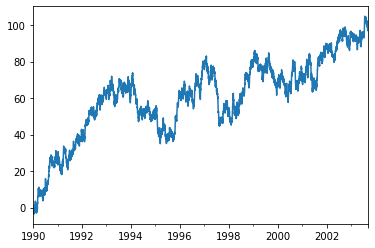

In [97]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [98]:
plt.show();

<Figure size 432x288 with 0 Axes>

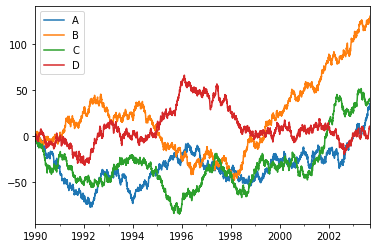

In [99]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [100]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [101]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,0.144736,-1.039755,-1.815495,-0.182500
1,1990-01-02,0.940107,-2.519819,0.821940,1.201054
2,1990-01-03,1.120124,-2.520183,0.716086,0.145945
3,1990-01-04,2.063689,-0.564746,-0.787430,-1.458448
4,1990-01-05,1.126625,-1.296174,-2.192960,-3.235625
...,...,...,...,...,...
4995,2003-09-05,33.568136,126.818051,39.631660,9.434868
4996,2003-09-06,32.919220,128.033899,39.311662,9.825097
4997,2003-09-07,34.992952,129.328883,39.885935,9.533894
4998,2003-09-08,33.274118,129.652862,39.981235,9.632867


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [102]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [103]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,0.144736,-1.039755,-1.815495,-0.182500
1990-01-02,0.940107,-2.519819,0.821940,1.201054
1990-01-03,1.120124,-2.520183,0.716086,0.145945
1990-01-04,2.063689,-0.564746,-0.787430,-1.458448
1990-01-05,1.126625,-1.296174,-2.192960,-3.235625
...,...,...,...,...
2003-09-05,33.568136,126.818051,39.631660,9.434868
2003-09-06,32.919220,128.033899,39.311662,9.825097
2003-09-07,34.992952,129.328883,39.885935,9.533894
2003-09-08,33.274118,129.652862,39.981235,9.632867


##Excel

Reading & writing to Excel.

Writing to an excel file using `DataFrame.to_excel()`:

In [104]:
df.to_excel("foo.xlsx", sheet_name="Sheet1")

In [105]:
pd.read_excel("foo.xlsx", "Sheet1", index_col=None, na_values=["NA"])

,Unnamed: 0,A,B,C,D
0,1990-01-01,0.144736,-1.039755,-1.815495,-0.182500
1,1990-01-02,0.940107,-2.519819,0.821940,1.201054
2,1990-01-03,1.120124,-2.520183,0.716086,0.145945
3,1990-01-04,2.063689,-0.564746,-0.787430,-1.458448
4,1990-01-05,1.126625,-1.296174,-2.192960,-3.235625
...,...,...,...,...,...
4995,2003-09-05,33.568136,126.818051,39.631660,9.434868
4996,2003-09-06,32.919220,128.033899,39.311662,9.825097
4997,2003-09-07,34.992952,129.328883,39.885935,9.533894
4998,2003-09-08,33.274118,129.652862,39.981235,9.632867


##Series
a one-dimensional labeled array capable of holding any data type(integers, strings, ..etc)

`s = pd.Series(data, index=index)`


###**From ndarray**

If `data` is an ndarray, index must be the same length as data. If no index is passed, one will be created having values `[0, ..., len(data) - 1]`.

In [110]:
# From ndarray
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
s

a    0.144757
b    1.927028
c    0.269754
d    1.974712
e   -0.870425
dtype: float64

In [111]:
s.index

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [113]:
pd.Series(np.random.randn(5))

0    0.654780
1    0.858499
2    0.692614
3   -0.884807
4   -0.999266
dtype: float64